# Siamese MLP Regression

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score

import sys
sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils.datasets import SiameseDataset
from data_utils.load_immuno import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from smlp import ConcatSiameseRMLP

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

## Data

In [6]:
datadir = '../../data/regress_immuno'
data = to_namedtuple(to_tensor(load_immuno(datadir, x_type='embeddings'), device))

In [4]:
train_X = data.train.x
validation_X = data.validation.x
test_X = data.test.x

In [7]:
emb_X = data.train.x

In [9]:
train_Y = data.train.y
validation_Y = data.validation.y
test_Y = data.test.y

In [44]:
dataset = SiameseDataset(train_X, train_Y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## Model

In [6]:
model = SiameseRMLP(
    in_features=train_X.shape[1], out_features=train_Y.shape[1], 
    depth=2, width=512, 
    dropout=0.4, 
).to(device)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train Statistics
validation_losses, train_losses, validation_scores = [], [], []

In [8]:
# Train Loop
for epoch in range(1):

    # SGD Loop
    for batch_i, (x1, x2, y1, y2) in tqdm(enumerate(dataloader)):

        model.train()
        
        optimizer.zero_grad()
        
        torch.nn.functional.mse_loss(
            model.siamese_forward(x1, x2), 
            y1 - y2
        ).backward()
        
        if batch_i % 32 == 0:

            model.eval()
            
            sample_1 = torch.randint(len(train_X), (64, ))
            sample_2 = torch.randint(len(train_X), (64, ))
            
            train_losses.append(float(torch.nn.functional.mse_loss(
                model.siamese_forward(
                    train_X[sample_1], train_X[sample_2]
                ).detach(), 
                train_Y[sample_1] - train_Y[sample_2]
            )))
            
            sample_3 = torch.randint(len(validation_X), (64, ))
            sample_4 = torch.randint(len(train_X), (64, ))

            y_pred = model.siamese_forward(
                validation_X[sample_3], train_X[sample_4]
            ).detach() + train_Y[sample_4]
            y_true = validation_Y[sample_3]
            
            validation_losses.append(float(torch.nn.functional.mse_loss(
                y_pred, y_true
            )))
            validation_scores.append(r2_score(
                y_true.cpu(), y_pred.cpu(), 
                multioutput='raw_values'
            ))
        
        optimizer.step()

model.eval();

253472it [10:28, 403.31it/s]


Text(0, 0.5, '$R^2$')

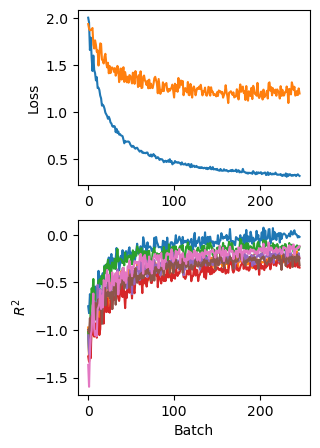

In [9]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(3, 5))

ax0.plot([sum(train_losses[i:i+32])/32 for i in range(0, len(train_losses), 32)][:-1])
ax0.plot([sum(validation_losses[i:i+32])/32 for i in range(0, len(validation_losses), 32)][:-1])
ax0.set_ylabel('Loss')

ax1.plot([sum(validation_scores[i:i+32])/32 for i in range(0, len(validation_scores), 32)][:-1])
ax1.set_xlabel('Batch')
ax1.set_ylabel('$R^2$')

In [10]:
torch.save(model.state_dict, './weights/2epochs.pt')

## Visualization

In [11]:
x, y_true = test_X, test_Y

### Error scaling

In [13]:
d_preds = []
d_trues = []

for i in range(len(test_X)):

    x_test = test_X[i].unsqueeze(0).expand(len(train_X), 512)
    y_test = test_Y[i].unsqueeze(0).expand(len(train_X), 7)
    
    d_pred = model.siamese_forward(x_test, train_X).detach().cpu()
    d_true = (y_test - train_Y).detach().cpu()

    d_preds.append(d_pred)
    d_trues.append(d_true)

d_preds = torch.concat(d_preds)
d_trues = torch.concat(d_trues)

## Similarity

In [10]:
# Compare structure similarity with property differences

indices = list(range(len(train_X)))
np.random.shuffle(indices)
i1 = indices[:1000]
i2 = indices[1000:2000]

fp1 = fp_X[i1].bool()
fp2 = fp_X[i2].bool()

emb1 = emb_X[i1]
emb2 = emb_X[i2]

intersection = torch.sum(fp1 & fp2, dim=1)
union = torch.sum(fp1 | fp2, dim=1)

d_tanimoto = (intersection/union).nan_to_num(0).unsqueeze(1).expand(1000, 7)

d_preds = train_Y[i1] - train_Y[i2]

In [41]:
# Compare structure similarity with property differences

indices = list(range(len(train_X)))
np.random.shuffle(indices)
i1 = indices[:1000]
i2 = indices[1000:2000]

fp1 = fp_X[i1].bool()
fp2 = fp_X[i2].bool()

emb1 = emb_X[i1]
emb2 = emb_X[i2]

intersection = torch.sum(fp1 & fp2, dim=1)
union = torch.sum(fp1 | fp2, dim=1)
s_tanimoto = (intersection/union).nan_to_num(0)
s_cosine = torch.sum(emb1 * emb2, dim=1)

d_preds = (torch.abs(train_Y[i1] - train_Y[i2])).sum(dim=1)

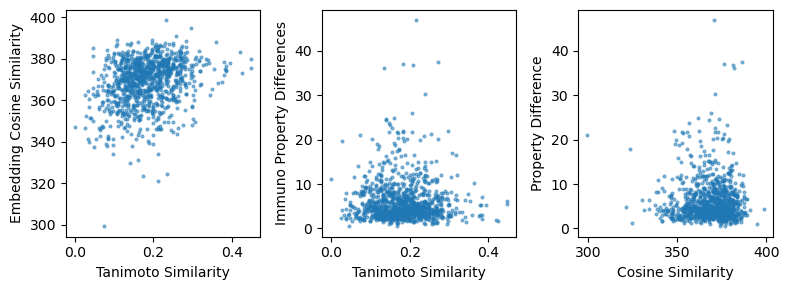

In [42]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 3))

ax0.scatter(s_tanimoto, s_cosine, s=4, alpha=0.5)
ax0.set_xlabel('Tanimoto Similarity')
ax0.set_ylabel('Embedding Cosine Similarity')
#ax0.set_title('Are similarity measures correlated?')

ax1.scatter(s_tanimoto, d_preds, s=4, alpha=0.5)
ax1.set_xlabel('Tanimoto Similarity')
ax1.set_ylabel('Property Differnece')

ax2.scatter(s_cosine, d_preds, s=4, alpha=0.5)
ax2.set_xlabel('Cosine Similarity')
ax2.set_ylabel('Property Difference')

plt.tight_layout()

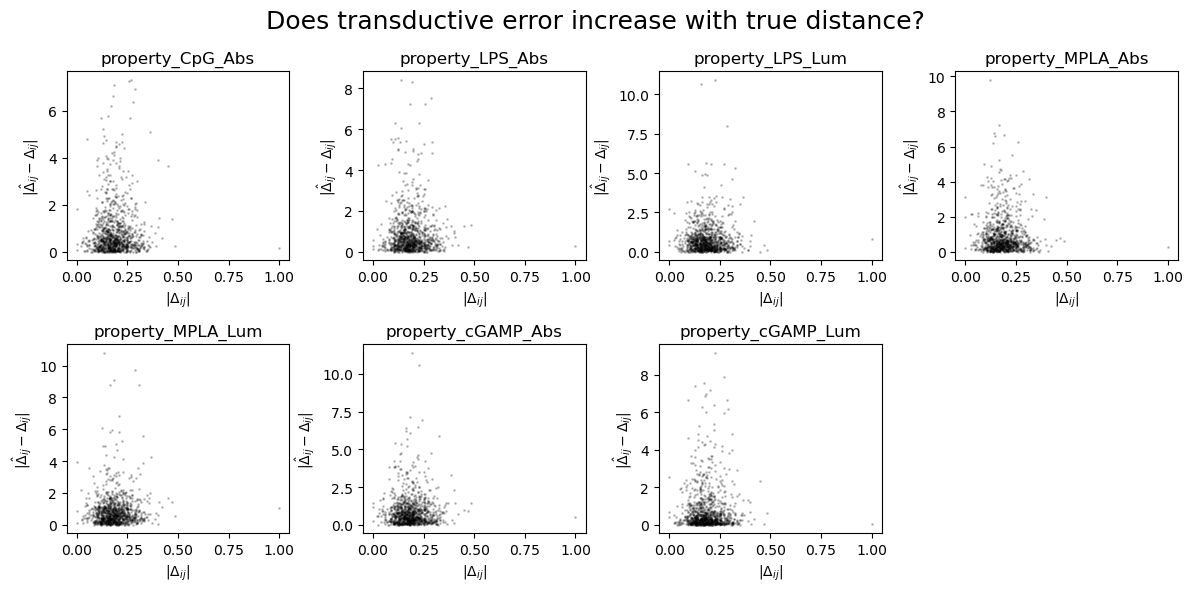

In [9]:
n_rows = n_cols = int((d_preds.shape[1]) ** 0.5)
while (n_rows * n_cols) < d_preds.shape[1]: n_cols += 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axs = [axs] if d_preds.shape[1] == 1 else axs.flatten()

for i, property_label in enumerate(data.properties):

    ax = axs[i]

    ax.scatter(d_trues[:, i], torch.abs(d_preds[:, i]), s=1, c='black', alpha=0.2)
    ax.set_xlabel('$|\Delta_{ij}|$')
    ax.set_ylabel('$|\hat{\Delta}_{ij} - \Delta_{ij}|$')
    ax.set_title(property_label)

axs[-1].axis('off')

fig.suptitle('Does transductive error increase with true distance?', fontsize=18)
plt.tight_layout()

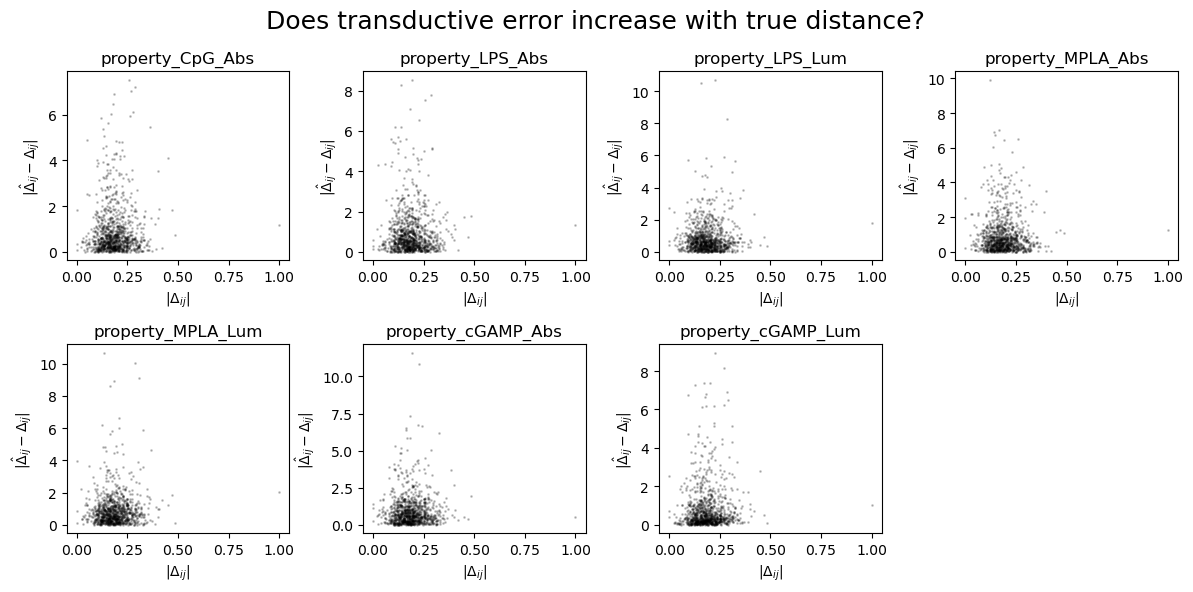

In [7]:
n_rows = n_cols = int((d_preds.shape[1]) ** 0.5)
while (n_rows * n_cols) < d_preds.shape[1]: n_cols += 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axs = [axs] if d_preds.shape[1] == 1 else axs.flatten()

for i, property_label in enumerate(data.properties):

    ax = axs[i]

    #ax.scatter(torch.abs(d_trues[:, i]), torch.abs(d_preds[:, i] - d_trues[:, i]), s=0.25, c='black', alpha=0.002)
    ax.scatter(torch.abs(d_trues[:, i]), torch.abs(d_preds[:, i] - d_trues[:, i]), s=1, c='black', alpha=0.2)
    ax.set_xlabel('$|\Delta_{ij}|$')
    ax.set_ylabel('$|\hat{\Delta}_{ij} - \Delta_{ij}|$')
    ax.set_title(property_label)

axs[-1].axis('off')

fig.suptitle('Does transductive error increase with true distance?', fontsize=18)
plt.tight_layout()

### Scatterplot

In [16]:
d_pred = []
d_true = []

n = 512
for i in tqdm(range(n)):
    
    sample_indices = torch.randint(len(train_X), (len(x), ))

    d_pred.append(model.siamese_forward(x, train_X[sample_indices]).detach().cpu())
    d_true.append((test_Y - train_Y[sample_indices]).detach().cpu())

100%|████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 1896.33it/s]


In [17]:
scores = r2_score(y_true.cpu(), y_pred.cpu(), multioutput='raw_values')
print(scores)

[ 0.08459105 -0.07628948  0.08791926  0.01135372  0.03773288 -0.05824046
  0.05270625]


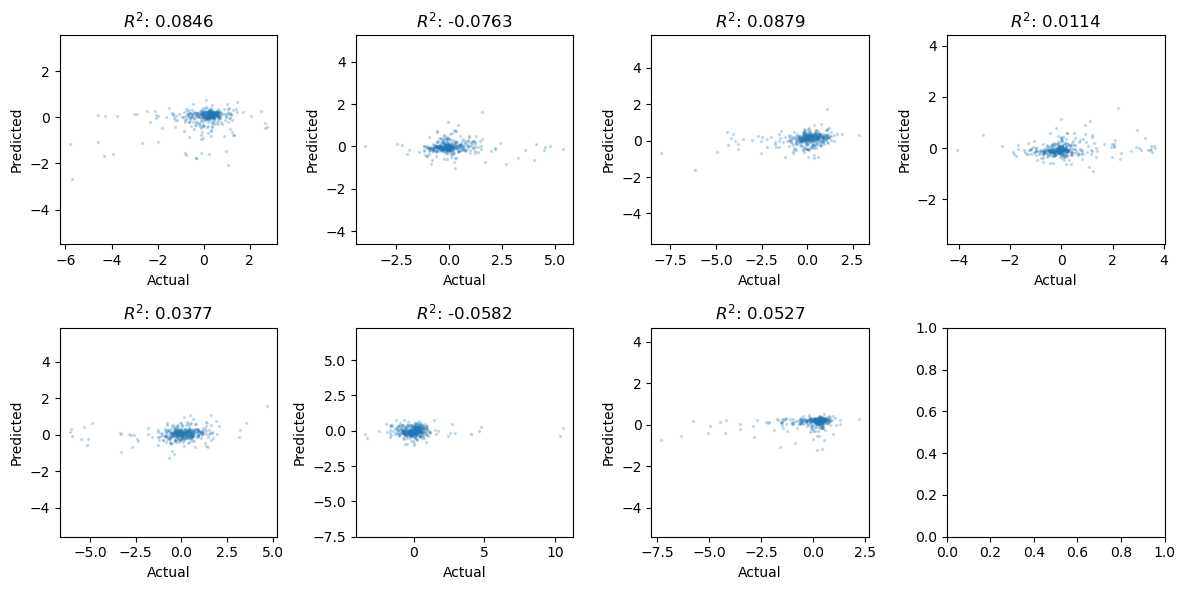

In [18]:
n_rows = n_cols = int((y_pred.shape[1]) ** 0.5)
while (n_rows * n_cols) < y_pred.shape[1]: n_cols += 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axs = [axs] if y_pred.shape[1] == 1 else axs.flatten()

for i in range(y_pred.shape[1]):

    ax = axs[i]

    ax.scatter(y_true[:, i].cpu(), y_pred[:, i].cpu(), s=2, alpha=0.2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'$R^2$: {scores[i]:.4f}')
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()